### LCLS II Hard X-Ray Front-End Attenuator System Workbook
*Rajan Plumley, LCLS Photon Controls & Data Systems*
#### Table of Contents
1. [Python implementation](#python)
2. [Demo](#demo)
2. [Calculations and semi-empirical data](#calculations)

**References:**

_B.L. Henke, E.M. Gullikson, and J.C. Davis, X-ray interactions: photoabsorption, scattering, transmission, and reflection at E=50-30000 eV, Z=1-92, Atomic Data and Nuclear Data Tables 54 no.2, 181-342 (July 1993)._

_B.D. Cullity, Elements of X-Ray Diffraction (Second Edition), 11-20, (1978)._ 

### Python implementation  <a name="python"></a>

In [1]:
import numpy as np; from matplotlib import pyplot as plt; import h5py; import itertools;

In [2]:
class satt:
    def __init__(self, filters, eV = None):
        self.filters = filters
        self.N_filters = len(filters)
        self.config = self._config()
        self.eV = None
        if eV:
            self.set_eV(eV)
        
    def blade(self, index):
        """
        Returns the filter object at `index`.
        """
        return self.filters[index]
    
    def _config(self):
        """
        Get the current configuration of filter blade states.
        """
        self.config = [ blade.state for blade in self.filters ]
        return self.config
    
    def set_config(self, config):
        """
        Moves filters to match arrangement given in `config`.
        """
        for blade in range(len(config)):
            self.filters[blade].state = config[blade]
        self._config()
    
    def _reset_blades(self):
        """
        Sets all filter blades to their default `in` position.
        """
        self.set_config(np.ones_like(self.config))

    def all_in(self):
        """
        Move all filter blades in.
        """
        self._reset_blades()
    
    def all_out(self):
        """
        Move all filter blades out.
        """
        self.set_config(np.zeros_like(self.config))
    
    def insert(self, index):
        """
        Insert a filter at `index`.
        """
        self.blade(index).state = 1
        self._config()

    def retract(self, index):
        """
        Retract a filter at `index`.
        """
        self.blade(index).state = 0
        self._config()

    def T(self, eV=None):
        """
        Calculates and returns transmission at 
        photon energy `eV` through current filter configuration.
        """
        if not eV and not self.eV:
            print("Photon energy not set.  Transmission undefined")
            return np.nan
        else:
            if not eV:
                eV = self.eV
        T = 1.0
        for f in self.filters:
            if f.is_in():
                T*=f.get_vals(eV)[1]
        return T

    def _calc_T(self, eV, config, filters):
        """
        Calculates and returns transmission at
        photon energy `eV` given an arbitrary configuration.
        """
        T = 1.0
        for i in range(len(config)):
            if config[i] == 1:
                T*=filters[i].get_vals(eV)[1]
        return T
         
    def _create_lookup(self, eV):
        """
        Find all possible configurations and calculate
        their transmissions at photon energy `eV`.
        """
        dtype=[('config',int),('T',float)]
        data = []
        configs = map(list, itertools.product([0, 1], repeat=self.N_filters))
        for i in range(2**self.N_filters):
            pair = (configs[i], self._calc_T(eV, configs[i], self.filters))
            data.append(pair)
        self.T_lookup_table = sorted(data, key=lambda x: x[1])
        return np.asarray(self.T_lookup_table)
    
    def set_eV(self, eV):
        """
        Sets the working photon energy and creates 
        a transmission lookup table.
        """
        self.eV = eV
        self.T_lookup_table = self._create_lookup(self.eV)
        
        
    def set_attenuation(self, T_desired, eV=None):
        """
        Find and set the configuration that has transmission closest (upper bound)
        to `T_desired` at photon energy `eV`. 
        """
        if self.eV:
            T_table = self.T_lookup_table
        if eV:
            T_table = self._create_configs(eV)
        new_config = None
        for i in range(1,len(T_table)):
            if T_table[i-1,1] < T_desired <= T_table[i,1]:
                new_config = T_table[i,0]
        if not new_config:
            print("Requested transmission not possible at this energy.")
        else:
            self._reset_blades()
            self.set_config(new_config)

In [3]:
class filter:
    def __init__(self, formula, d, index, h5file):
        self.formula = formula # chemical formula
        self.d = d # filter thickness
        self.index = index 
        self.constants, self._table = self.load_data(h5file)
        self.Z = int(self.constants[0]) # atomic number
        self.A = self.constants[1] # atomic weight [g]
        self.p = self.constants[2] # density [g/cm^3]
        self.table = self._T_table()
        self.state = 1
        
    def load_data(self, h5file):
        """
        Loads HDF5 physics data into tables.
        """
        self.table = np.asarray(h5file['{}_scatter_table'.format(self.formula)])
        self.constants = np.asarray(h5file['{}_constants'.format(self.formula)])
        return self.constants, self.table
    
    def _T_table(self):
        """
        Creates table of transmissions based on filter thickness `d`.
        """
        t_table = np.zeros([self._table.shape[0],2])
        for i in range(self._table.shape[0]):
            t_table[i] = self._table[i,0], np.exp(-self._table[i,2]*self.d*10) 
        self.T_table = t_table
        return self.T_table
        
    def plot_T(self,xmin=0,xmax=8000):
        """
        Plot this filter's transmission vs photon energy.
        """
        plt.plot(self.T_table[:,0],self.T_table[:,1], c='black', linewidth=0.7)
        plt.ylabel("Transmission")
        plt.xlabel("Photon Energy (eV)")
        plt.xlim(xmin,xmax)
        plt.title("{0}(Z = {1}): {2}um thickness".format(self.formula, self.Z, self.d*1E6))
        
    def get_vals(self, eV):
        """
        Return closest photon energy to eV and its transmission
        """
        T  = np.nan
        closest_eV = (min(self.T_table[:,0], key=lambda data_eV:abs(data_eV-eV)))
        i = np.argwhere(self.T_table[:,0]==closest_eV).flatten()[0]
        eV, T = self.T_table[i]
        return closest_eV, T
    
    def is_in(self):
        """
        Filter state as a boolean.
        """
        if int(self.state) == 1:
            return True
        else:
            return False

### Python demo <a name="demo"></a>

Upon initialization, `filter` objects will reference a structured HDF5 file to calculate a transmission profile for their given material and thickness.

In [4]:
fData = h5py.File('./filter_data.h5', 'r') # A demo file containing atomic data for silicon and carbon

In [5]:
filters = [
    filter("C" , 0.5E-6, 0, fData),
    filter("C" , 0.6E-6, 1, fData),
    filter("C" , 1.2E-6, 2, fData),
    filter("C" , 2.4E-6, 3, fData),
    filter("C" , 4.8E-6, 4, fData),
    filter("Si", 0.2E-6, 5, fData),
    filter("Si", 0.8E-6, 6, fData),
    filter("Si", 1.6E-6, 7, fData),
    filter("Si", 2.0E-6, 8, fData),
    filter("Si", 2.4E-6, 9, fData),
]

The `satt` object eats the filter list in order to exist.

In [6]:
Satt = satt(filters)

The solid attenuator object contains and manages the set of `filter` objects. 
Each filter object is responsible for containing some information about itself.  By calling the solid attenuator `satt.blade` method, we can access each filter and ask for some data.

In [7]:
for i in range(Satt.N_filters):
    f = Satt.blade(i)
    print("Filter: {:<5} Atomic Number: {:<5} Thickness: {:<7} Density: {:<5}g/cm^3".format(f.index, f.Z, str(f.d*1E6)+'um', f.p))

Filter: 0     Atomic Number: 6     Thickness: 0.5um   Density: 3.51 g/cm^3
Filter: 1     Atomic Number: 6     Thickness: 0.6um   Density: 3.51 g/cm^3
Filter: 2     Atomic Number: 6     Thickness: 1.2um   Density: 3.51 g/cm^3
Filter: 3     Atomic Number: 6     Thickness: 2.4um   Density: 3.51 g/cm^3
Filter: 4     Atomic Number: 6     Thickness: 4.8um   Density: 3.51 g/cm^3
Filter: 5     Atomic Number: 14    Thickness: 0.2um   Density: 2.329g/cm^3
Filter: 6     Atomic Number: 14    Thickness: 0.8um   Density: 2.329g/cm^3
Filter: 7     Atomic Number: 14    Thickness: 1.6um   Density: 2.329g/cm^3
Filter: 8     Atomic Number: 14    Thickness: 2.0um   Density: 2.329g/cm^3
Filter: 9     Atomic Number: 14    Thickness: 2.4um   Density: 2.329g/cm^3


We can also use the `satt.blade` method to examine filters individually.

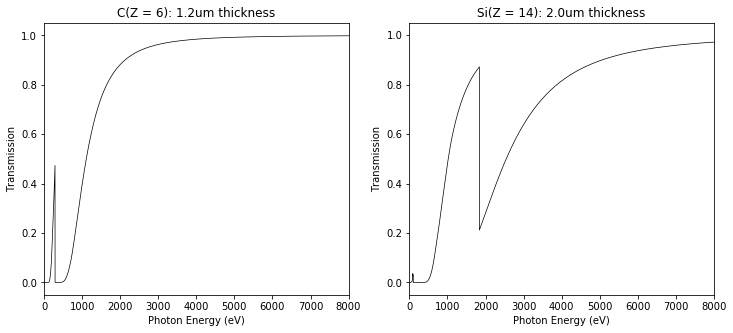

In [8]:
plt.figure(figsize=(12,5))
plt.subplot(121)
Satt.blade(2).plot_T()
plt.subplot(122)
Satt.blade(8).plot_T()
plt.show()

`satt` oversees the states of its filter blades.  Methods such as `insert` or `all_in` are used to control the filter states individually or in ensemble.

In [9]:
Satt.all_in()
print("Blade config: {:<20},  Transmission at 0.5keV: {:<20}".format(Satt.config, Satt.T(eV=500)))

Satt.all_out()
print("Blade config: {:<20},  Transmission at 0.5keV: {:<20}".format(Satt.config, Satt.T(eV=500)))

Blade config: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  Transmission at 0.5keV: 5.86999555612e-27   
Blade config: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  Transmission at 0.5keV: 1.0                 


Insert the first blade.

In [10]:
Satt.insert(0)
print("Blade config: {:<20},  Transmission at 0.5keV: {:<20}".format(Satt.config, Satt.T(eV=1000)))

Blade config: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  Transmission at 0.5keV: 0.681635988802      


The system can create tables of all filter combinations and calculates their transmissions.  It will use these later when determining the best configuration for a desired transmission.

In [11]:
print(Satt._create_lookup(eV=1000)[:8]) # some filter configurations

[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 5.346538014077074e-05]
 [[1, 1, 1, 1, 1, 0, 1, 1, 1, 1] 5.7513595439342245e-05]
 [[1, 1, 1, 1, 1, 1, 0, 1, 1, 1] 7.1591934165767568e-05]
 [[1, 1, 1, 1, 1, 0, 0, 1, 1, 1] 7.7012629995126854e-05]
 [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1] 7.8436850487830246e-05]
 [[0, 1, 1, 1, 1, 0, 1, 1, 1, 1] 8.4375819915908149e-05]
 [[1, 0, 1, 1, 1, 1, 1, 1, 1, 1] 8.4685614747012132e-05]
 [[1, 0, 1, 1, 1, 0, 1, 1, 1, 1] 9.1097719183287547e-05]]


When a photon energy is set using the `satt.set_eV` method, a table of filter combinations and transmissions is created, sorted, and saved.  When `satt.set_attenuation` is called with a desired transmission, the system rounds up to the nearest tabulated transmission and sets itself to the corrosponding blade configuration.

In [12]:
Satt.set_eV(1000)

Satt.set_attenuation(0.64)    # set 64% transmission
print("Blade config: {:<20},  Transmission at {}keV: {:<20}".format(Satt.config,Satt.eV,Satt.T()))

Blade config: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  Transmission at 1000keV: 0.681635988802      


### Calculations and semi-empirical data  <a name="calculations"></a>

So far, the solid attenuator system uses a semi-empirical treatment of x-ray absorption to approximate transmissions through filters of arbitrary thickness.  Absorption due to inelastic scattering is not considered.

Transmissions for photon energy ranging 50-30,000eV are calculated using atomic scattering factor measurements provided by [_B.L. Henke, E.M. Gullikson, and J.C. Davis_](http://henke.lbl.gov/optical_constants/asf.html).

**TL;DR:** Some numbers are taken from a table and Beer's law does the rest.

In [13]:
si_fs = np.load('scattering_factors/si.npy') # Silicon scattering factors
print("eV                   f1                f2")
print(si_fs)

eV                   f1                f2
[[  1.00000000e+01  -9.99900000e+03   3.94851000e+00]
 [  1.01617000e+01  -9.99900000e+03   3.95531000e+00]
 [  1.03261000e+01  -9.99900000e+03   3.96212000e+00]
 ..., 
 [  2.90639000e+04   1.40291000e+01   2.44301000e-02]
 [  2.95339000e+04   1.40279000e+01   2.36157000e-02]
 [  3.00000000e+04   1.40269000e+01   2.28464000e-02]]


Some material properties and physical constants are needed.

In [14]:
r0 = 2.8719E-15  # classical electron radius [m]
h = 6.626176E-34 # plancks constant [j s]
c = 2.9979E8     # Speed of light [m s^-1]
Na = 6.022E23    # Avagadros number 
A_Si = 4.6637E-23# atomic weight of silicon in grams [g]
p_Si = 2.329     # density of silicon [g/cm^3]

Given photon wavelength $\lambda$, the atomic photoabsorption cross-section for an element is found semi-empirically using the known atomic scattering factor $f_2$.

$$ \sigma_a = 2 r_0 \lambda f_2 $$

http://henke.lbl.gov/optical_constants/intro.html

The mass absorption coefficient is proportional to the atomic photoabsorption cross-section by Avagadros number $N_A$ and atomic weight $A$.

$$\mu_m = \frac{N_A}{A} \sigma_a$$

http://xdb.lbl.gov/Section1/Sec_1-6.pdf

For our purposes, we can think of the filters as semi-infinite solids and only need to consider the linear depth of material the beam must transmit through.  Let $\mu$ be the linear absorption factor that has dimension of inverse length $\big[ l^{-1} \big]$.  We can obtain this for a material by multiplying its mass absorption coefficient by its density $\rho$.

$$\mu= \mu_m \rho = 2 r_0 \lambda f_2 \frac{N_A}{A}\rho$$

In [15]:
def mu(fs, A, p):
    return (2*r0*h*c*fs[:,2]/fs[:,0])*p*(Na/A)

The linear attenuation can now be described using the Beer-Lambert relation,

$$I = I_0 e^{-\mu d}$$

where $d$ is the linear depth of attenuating material.  Given that we know the value of $f_2$ at a certain photon energy, we have what we need to approximate the transmission through a filter of any thickness $d$.

$$ T = \frac{I}{I_0} = e^{-\mu d} = e^{-2 r_0 \lambda f_2 \frac{N_A}{A}\rho d}$$

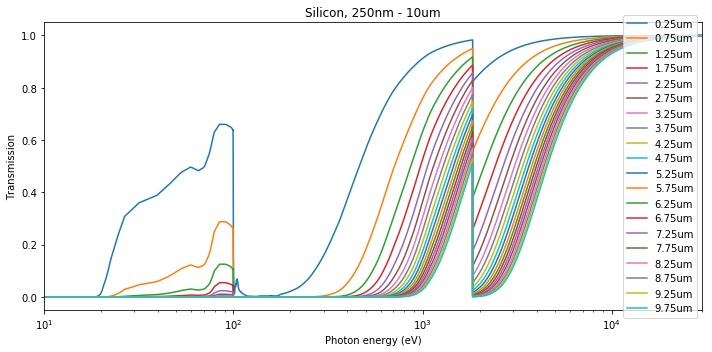

In [16]:
fig = plt.figure(figsize=(10,5))
for d in np.arange(2.5E-7,1E-5,5E-7):
    plt.plot(si_fs[:,0],np.exp(-mu(si_fs,A_Si,p_Si)*d*10),linewidth=1.5, label="{}um".format(d*1E6))
plt.xlim(10,30000)
plt.title("Silicon, 250nm - 10um")
plt.ylabel("Transmission")
plt.xlabel("Photon energy (eV)")
plt.xscale('log')
plt.tight_layout()
plt.legend(loc=5, bbox_transform=fig.transFigure)
plt.show()

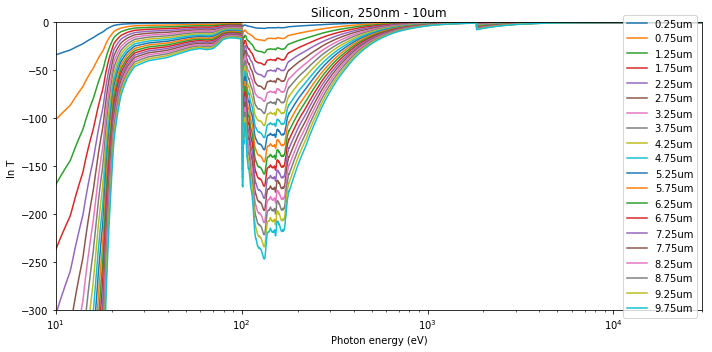

In [17]:
fig = plt.figure(figsize=(10,5))
for d in np.arange(2.5E-7,1E-5,5E-7):
    plt.plot(si_fs[:,0],-mu(si_fs,A_Si,p_Si)*d*10,linewidth=1.5, label="{}um".format(d*1E6))
plt.title("Silicon, 250nm - 10um")
plt.ylabel("ln T "); plt.ylim(-300,0);
plt.xlabel("Photon energy (eV)")
plt.xscale('log')
plt.xlim(10,30000)
plt.tight_layout()
plt.legend(loc=5, bbox_transform=fig.transFigure)
plt.show()

The exponential formula for transmission makes calculating the total transmission for a configuration of filters straight-forward.  To consider filter states, let $\delta = 1$ if the filter is inserted and $\delta = 0$ if the filter is retracted.

$$ T_{tot} = e^{\sum_i -\delta_i \mu_i d_i} = e^{-\delta_1 \mu_1 d_1}e^{-\delta_2 \mu_2 d_2} \dots e^{-\delta_N \mu_N d_N} = \prod_i T_i (\delta_{i})$$